In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
import pmdarima as pm
import warnings
from pmdarima.model_selection import train_test_split
from darts import utils
from darts.models import RegressionModel
from darts.models import BlockRNNModel
from darts.models import NaiveSeasonal
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.metrics import mape
from darts.metrics import rmse

In [2]:
#path to the data folder, edit if necesssary
path = "./data/Generated Data/"

#Price Files 
gas_prices = 'gas_prices.csv'
power_prices = 'power_prices.csv'

#Master files
master_power = 'master_competitor_market_prices_power.csv'
master_gas = 'master_competitor_market_prices_gas.csv'

#Strategy Index aggregated files
power_strat = 'Strat_competitor_market_prices_power.csv'
gas_strat = 'Strat_competitor_market_prices_gas.csv'


In [3]:
#Reading in relevant datasets
df_power = pd.read_csv(path + master_power)
df_gas = pd.read_csv(path + master_gas)
df_power_strat = pd.read_csv(path + power_strat)
df_gas_strat = pd.read_csv(path + gas_strat)
df_power_prices = pd.read_csv(path + power_prices)
df_gas_prices = pd.read_csv(path + gas_prices)

df_power_strat

,valid_range,price_kwh,price_kwh_2,price_kwh_3,price_kwh_4,price_kwh_5,spot_peak,spot_base,y_ahead_peak,2y_ahead_peak,...,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak,avg_price
0,2021-05-25,NaN,0.632290,NaN,NaN,NaN,0.059137,0.059780,0.07547,0.07268,...,0.06497,0.06166,0.05990,0.05914,0.05978,0.06477,0.07686,0.07140,0.09149,0.067694
1,2021-05-26,NaN,0.632290,NaN,NaN,NaN,0.066537,0.065606,0.07700,0.07315,...,0.06621,0.06218,0.06022,0.06654,0.06561,0.06691,0.07914,0.07363,0.09396,0.070549
2,2021-05-27,NaN,0.632290,NaN,NaN,NaN,0.073451,0.071767,0.07505,0.07182,...,0.06424,0.06053,0.05883,0.07345,0.07177,0.06582,0.07658,0.07216,0.09086,0.071198
3,2021-05-28,NaN,0.632290,NaN,NaN,NaN,0.073578,0.073602,0.07430,0.07108,...,0.06396,0.06008,0.05813,0.07358,0.07360,0.06496,0.07589,0.07065,0.09033,0.070946
4,2021-05-29,NaN,0.632290,NaN,NaN,NaN,0.045801,0.056488,0.07405,0.07075,...,0.06352,0.05984,0.05785,0.04580,0.05649,0.05335,0.06840,0.07043,0.09033,0.063041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2022-10-11,0.570836,0.808766,0.874903,1.452545,NaN,0.291781,0.259874,0.58540,0.35550,...,0.43564,0.27000,0.19492,0.29178,0.25987,0.34531,0.39827,0.46967,0.49292,0.350317
505,2022-10-12,0.570836,0.838389,0.856027,1.452545,NaN,0.299797,0.282536,0.59000,0.35546,...,0.43400,0.26800,0.19388,0.29980,0.28254,0.34197,0.38953,0.45450,0.48541,0.352217
506,2022-10-13,0.570552,0.805243,0.870350,1.452848,NaN,0.287573,0.257456,0.58415,0.35350,...,0.42400,0.26801,0.18524,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342566
507,2022-10-14,0.570552,0.805243,0.870350,1.452848,NaN,0.283842,0.260646,0.58415,0.35350,...,0.42400,0.26801,0.18524,0.28757,0.25746,0.33663,0.38304,0.44929,0.47385,0.342528


In [4]:
#Setting right indices for price data
df_power_prices.set_index('Dates', drop = True, inplace= True)
df_gas_prices.set_index('date', drop = True, inplace= True)

#Datetime conversion 
df_power_prices.index = pd.to_datetime(df_power_prices.index)
df_gas_prices.index = pd.to_datetime(df_gas_prices.index)


In [25]:
def querySingleTariffRange(rank = (1,5), post_code = 81737, consumption_range = 2500, data = df_power) -> pd.DataFrame:

    res = data.loc[(data['rank'] >= rank[0]) & (data['rank'] <= rank[1]) & (data.post_code == post_code) & (data.consumption_range_kwh == consumption_range)].copy()
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

In [64]:
def eval_linear_model(model, target, covariates, days = 1, train_size = 0.8):

    #Defining test dataset
    p_train, _ = target.split_before(train_size)
    model.fit(p_train, past_covariates= covariates)
        
    # We backtest the model on the last part of the timeseries:
    backtest = model.historical_forecasts(series=target, 
                                            past_covariates=covariates,
                                            start=train_size, 
                                            retrain=True,
                                            verbose=False, 
                                            forecast_horizon=days)
    return mape(target, backtest)


def evaluate_models(target, covariates, lags, lags_covs, days = 1, train_size = 0.80):
    days = max(days, 1)
    best_score, best_cfg = float("inf"), None
    for l in lags:
        for c in lags_covs:
            try:
                reg_model = RegressionModel(lags = l, lags_past_covariates= c, output_chunk_length=days)
                mape = eval_linear_model(reg_model, target, covariates, days, train_size)
                if mape < best_score:
                    best_score, best_cfg = mape, (l, c)
            except:
                print('error in model eval')
                continue
    #print('Best ModelA%s MAPE=%.6f' % (best_cfg, best_score))
    return best_cfg

def scaleTimeSeries(timeseries):
    scaler = Scaler()
    series_scaled = scaler.fit_transform(timeseries)
    return series_scaled



def denormalize(y, y_max_pre_normalize, y_min_pre_normalize):
    final_value = y * (y_max_pre_normalize - y_min_pre_normalize) + y_min_pre_normalize 
    return final_value

In [65]:
def provideForecasts(postcode, consumption_range, rank_range, household_data, price_data, days):

    #Querying dataset
    df = querySingleTariffRange(rank_range, postcode, consumption_range, household_data)
    
    if not df.shape[0]:
        print('No data found.')
        return

    #Shifting prices by 1 to avoid look-ahead bias
    real_prices = df.price_kwh
    df = df.shift(1)
    df.price_kwh = real_prices

    #Merging price data
    df = df.join(price_data)

    #Adding rolling moving average as additional covariate
    df['moving_average'] = df.avg_price.ewm(alpha=0.1, adjust=False).mean()

    #Dropping resulting NA column
    df.dropna(inplace=True)
    
    ##Building TimeSeries objects, and filling in missing date indices
    past_covs = utils.missing_values.fill_missing_values(TimeSeries.from_dataframe(df[['avg_price', 'moving_average']], fill_missing_dates= True))
    prices = utils.missing_values.fill_missing_values(TimeSeries.from_dataframe(df[['price_kwh']], fill_missing_dates= True))

    #defining pre scaled min and max prices for denormalization of predictions
    prices_min = prices.values().min()
    prices_max = prices.values().max()

    #Scaling both timeseries
    past_covs = scaleTimeSeries(past_covs)
    prices = scaleTimeSeries(prices)

    #Defining train datasets
    past_covs_train = past_covs[:-days]
    prices_train = prices[:-days]
    prices_valid = prices[-days:]

    #Defining hyperparam grid for linear regression model
    lags = [1,2,3,4,5]
    cov_lags = [1,2,3,4,5]

    #Finding optimal lags
    l, c = evaluate_models(prices_train, past_covs_train, lags, cov_lags, days)

    #Defining Benchmark
    benchmark = NaiveSeasonal(K=1)
    benchmark.fit(prices_train)
    bm = benchmark.predict(days)


    reg_model = RegressionModel(l, c, output_chunk_length=days)
    reg_model.fit(prices_train, past_covs_train)
    rnn_model = BlockRNNModel(model="LSTM", n_epochs=100, random_state=42, input_chunk_length= 1, output_chunk_length=days)
    rnn_model.fit(prices_train, past_covariates=past_covs_train, verbose = False)
    preds_rnn = rnn_model.predict(days, series = prices_train, past_covariates= past_covs_train)
    preds_reg = reg_model.predict(days, series = prices_train, past_covariates= past_covs_train)

    # prices.plot(label = 'timeseries')
    # bm.plot(label = 'benchmark')
    # preds_rnn.plot(label = 'LSTM predictions')
    # preds_reg.plot(label = 'Regression predictions')

    # print('LSTM MAPE: ', mape(preds_rnn, prices_valid))
    # print('Regression MAPE: ', mape(preds_reg, prices_valid))
    # print('Benchmark MAPE: ', mape(bm, prices_valid))


    res = [mape(preds_reg, prices_valid), mape(preds_rnn, prices_valid), mape(bm, prices_valid), rmse(preds_reg, prices_valid), rmse(preds_rnn, prices_valid), rmse(bm, prices_valid)]
    res = np.append(res, denormalize(preds_reg.values(), prices_max, prices_min).reshape(1, len(preds_reg)))
    res = np.append(res, denormalize(preds_rnn.values(), prices_max, prices_min).reshape(1, len(preds_rnn)))
    return res

In [67]:
import warnings
warnings.filterwarnings("ignore")

#Defining postcodes and consumption ranges
df_master = pd.DataFrame({'Postcodes': [], 'Consumption Range': [], 'Rank range': []})
df_res = pd.DataFrame(columns=['MAPE Linreg', 'MAPE LSTM', 'MAPE Benchmark', 'RMSE Linreg', 'RMSE LSTM', 'RMSE Benchmark'] + list(range(1,15)))
df_res = pd.concat([df_res, pd.DataFrame(columns=list(range(1,15))).add_suffix('_RNN')])
df_res

#Defining postcodes 
gas_postcodes = df_gas.post_code.unique()[:100]
pow_postcodes = df_power.post_code.unique()[:100]

#Consumption ranges
consumption_ranges = [2000]

#Rank ranges
ranks = [(1,5), (5,10), (10,15)]

for p in pow_postcodes:
    for c in consumption_ranges:
        for r in ranks:
            print(p, c, r)
            try:
                res = provideForecasts(p, c, r, df_power, df_power_prices, 14)
                row = [p, c, r]
                df_master.loc[len(df_master)] = row
                df_res.loc[len(df_res)] = res
            except:
                continue

pow_predictions = pd.concat([df_master, df_res], axis = 1)

51103 2000 (1, 5)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

51103 2000 (5, 10)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

51103 2000 (10, 15)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

51381 2000 (1, 5)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

51381 2000 (5, 10)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

51381 2000 (10, 15)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [68]:
pow_predictions

,Postcodes,Consumption Range,Rank range,MAPE Linreg,MAPE LSTM,MAPE Benchmark,RMSE Linreg,RMSE LSTM,RMSE Benchmark,1,...,5_RNN,6_RNN,7_RNN,8_RNN,9_RNN,10_RNN,11_RNN,12_RNN,13_RNN,14_RNN
0,51103,2000,"(1, 5)",3.823646,3.372967,6.006362,0.040277,0.037014,0.060003,0.750446,...,0.735598,0.747831,0.738522,0.743566,0.741489,0.733307,0.739112,0.733458,0.732500,0.734089
1,51103,2000,"(5, 10)",3.539117,3.719813,3.832408,0.047486,0.043742,0.038767,0.797709,...,0.769204,0.779406,0.769377,0.775626,0.770396,0.763187,0.765564,0.761127,0.757239,0.759998
2,51103,2000,"(10, 15)",4.395464,3.819748,6.157562,0.058825,0.050704,0.055115,0.845451,...,0.816332,0.826429,0.814383,0.817214,0.812946,0.805272,0.805794,0.801939,0.803881,0.811360
3,51381,2000,"(1, 5)",3.281760,3.480076,5.669109,0.039811,0.044911,0.062608,0.743809,...,0.729364,0.744036,0.733313,0.738751,0.735506,0.728711,0.733860,0.727063,0.725729,0.727684
4,51381,2000,"(5, 10)",4.698535,4.088701,3.980111,0.056701,0.048420,0.039910,0.789817,...,0.756112,0.771525,0.759675,0.764479,0.758529,0.750015,0.754044,0.749724,0.750091,0.763111
5,51381,2000,"(10, 15)",3.618174,3.555399,5.562180,0.048101,0.042100,0.052077,0.836182,...,0.807220,0.817152,0.804491,0.808498,0.801423,0.791914,0.792067,0.788852,0.783986,0.783163


0.7640063888888888


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

LSTM MAPE:  3.3729666660708917
Regression MAPE:  3.8236463670507197
Benchmark MAPE:  6.0063621872549104


<AxesSubplot: xlabel='valid_range'>

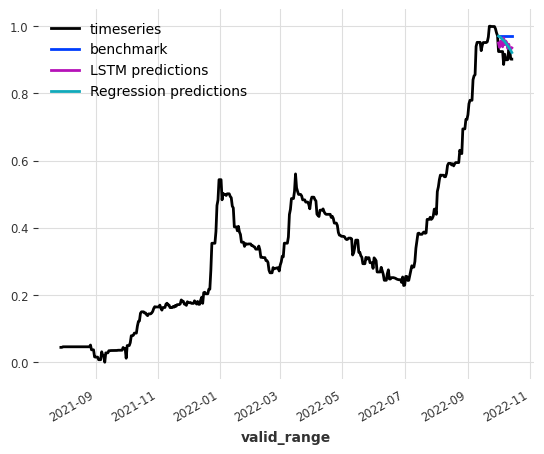

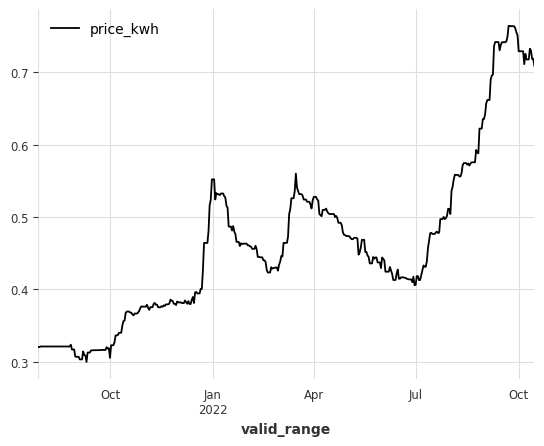

In [61]:
# df = querySingleTariffRange((1,5), 51103, 2000)
# df2 = querySingleTariffRange((5,10), 51103, 2000)
# df3 = querySingleTariffRange((10,15), 51103, 2000)

#df.join(df2, rsuffix='2').join(df3, rsuffix='3').plot()
provideForecasts(51103, 2000, (1,5), df_power, df_power_prices, 14)

In [ ]:
pow_predictions.to_csv(path + 'PowPredictions.csv', index= False)

In [ ]:
print(pow_predictions['MAPE Benchmark'].mean())
print(pow_predictions['MAPE LSTM'].mean())
print(pow_predictions['MAPE Linreg'].mean())

In [477]:
print(pow_predictions['RMSE Benchmark'].mean())
print(pow_predictions['RMSE LSTM'].mean())
print(pow_predictions['RMSE Linreg'].mean())

0.06319887649962865
0.05158136347057081
0.054336929389520144


In [ ]:
#Resetting dataframes
df_master = pd.DataFrame({'Postcodes': [], 'Consumption Range': [], 'Rank range': []})
df_res = pd.DataFrame(columns=['MAPE Linreg', 'MAPE LSTM', 'MAPE Benchmark', 'RMSE Linreg', 'RMSE LSTM', 'RMSE Benchmark'] + list(range(1,15)))
df_res = pd.concat([df_res, pd.DataFrame(columns=list(range(1,15))).add_suffix('_RNN')])
df_res

#Consumption ranges
consumption_ranges = [2500, 3000, 5000]

#Rank ranges
ranks = [(1,5), (5,10), (10,15)]

for p in gas_postcodes:
    for c in consumption_ranges:
        for r in ranks:
            print(p, c, r)
            try:
                res = provideForecasts(p, c, r, df_gas, df_gas_prices, 14)
                row = [p, c, r]
                df_master.loc[len(df_master)] = row
                df_res.loc[len(df_res)] = res
            except:
                continue

gas_predictions = pd.concat([df_master, df_res], axis = 1)

In [ ]:
gas_predictions.to_csv(path + 'GasPredictions.csv', index= False)

In [474]:

print(gas_predictions['MAPE Benchmark'].mean())
print(gas_predictions['MAPE LSTM'].mean())
print(gas_predictions['MAPE Linreg'].mean())

18.87995095704586
17.92142845196342
17.482446650386


In [476]:
print(gas_predictions['RMSE Benchmark'].mean())
print(gas_predictions['RMSE LSTM'].mean())
print(gas_predictions['RMSE Linreg'].mean())

0.15290555773367898
0.1471580705717864
0.14041000654727467
